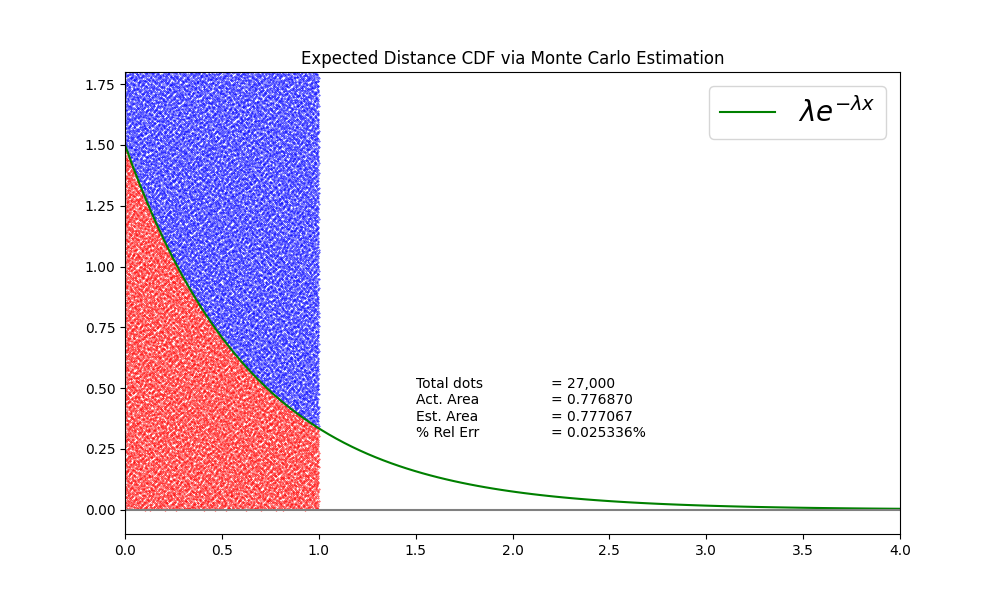

In [1]:
# Cell 1
# """mc_exp_dist.py"""

# Task 20-01
# Caroline Cummings

# A lot of code from mc_std_normal.ipynb

from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from numba import float64, vectorize  # type: ignore
from scipy.integrate import quad #type: ignore

# From D. Biersach to improve error
from matplotlib.patches import Rectangle

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

def f(x: NDArray[np.float_], rate_param: float) -> NDArray[np.float_]:
    # PDF of exponential distribution found from
    #https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/business/probability/exponential-distribution.html
    return rate_param * np.exp(-rate_param * x)

@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h

def plot_exp_dist(ax: Axes) -> None:
    # Minimum of 25,000 samples
    iterations: int = 27_000

    # Define rate parameter in hours
    rate: float = 1.5
    # Sample area big enough to include points above and below
    sample_area = Rectangle((0, 0), 1, 1.8)

    # 2 dimensions
    primes: list[int] = [2, 3]

    # Constrained x, y to be in sample space
    x: NDArray[np.float_] = sample_area.get_x() + \
        halton(np.arange(iterations), primes[0]) * sample_area.get_width()  # type: ignore
    y: NDArray[np.float_] = sample_area.get_y() + \
        halton(np.arange(iterations), primes[1]) * sample_area.get_height()  # type: ignore

    # Calculate distance above or below curve
    d: NDArray[np.float_] = f(x, rate) - y

    x_in: NDArray[np.float_] = x[d >= 0.0]
    y_in: NDArray[np.float_] = y[d >= 0.0]

    x_out: NDArray[np.float_] = x[d < 0.0]
    y_out: NDArray[np.float_] = y[d < 0.0]

    # Plot curve
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

    # Plot actual pdf curve
    act_x: NDArray[np.float_] = np.linspace(0, 4, 100)
    act_y: NDArray[np.float_] = f(act_x, rate)
    ax.plot(
        act_x, act_y, color="green", label=r"$\lambda e^{- \lambda x}$"
    )

    # Calculate percent relative error using width and height of rectangle - D. Biersach
    est_area: float = np.count_nonzero(d >= 0.0) / iterations \
        * sample_area.get_width() * sample_area.get_height()
    # Calculate integral using bounds of rectangle
    act_area: float = quad(f, sample_area.get_x(), sample_area.get_width(), args=(rate))[0] #type: ignore
    err: float = (est_area - act_area) / act_area #type: ignore

    ax.set_title("Expected Distance CDF via Monte Carlo Estimation")
    ax.set_xlim(0, 4.0)
    ax.set_ylim(-0.1, 1.8)
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.legend(loc="upper right", fontsize="20")

    ax.text(1.5, 0.3, "Total dots\nAct. Area\nEst. Area\n% Rel Err", ha="left")

    # fmt: off
    ax.text(2.2, 0.3,
        f"= {iterations:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}", ha="left")
    # fmt: on


def main() -> None:
    plt.close("all")
    # Sets the size of the window in inches
    plt.figure(" ", figsize=(10, 6))
    plot_exp_dist(plt.axes())
    plt.show()


main()